# Group Project - AI for Security

**Members:**
- Andrea Ferrazzano - andrea1.ferrazzano@mail.polimi.it - 10703279
- Marco Gorini - marco2.gorini@mail.polimi.it - 10710545
- Leonardo Saveri - leonardo.saveri@mail.polimi.it - 10745545
- Claudia Pierpaoli - claudia.pierpaoli@mail.polimi.it - 11016822

# Objective:
In this section of the project, we train linear classifiers and will evaluate:

### Accuracy
- **Explanation:** The overall correctness of predictions.
- **Formula:** $ \frac{TP + TN}{TP + TN + FP + FN} $

### Precision
- **Explanation:** Proportion of true positives among all positive predictions.
- **Formula:** $ \frac{TP}{TP + FP} $

### Recall (Sensitivity or True Positive Rate)
- **Explanation:** Proportion of actual positives correctly predicted.
- **Formula:** $ \frac{TP}{TP + FN} $

### Specificity (True Negative Rate)
- **Explanation:** Proportion of actual negatives correctly predicted.
- **Formula:** $ \frac{TN}{TN + FP} $

### F1 Score
- **Explanation:** Harmonic mean of precision and recall, balances both.
- **Formula:** $ \frac{2TP}{2TP + FP + FN} $

## Imports

In [42]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from joblib import dump, load

from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import time

# Preparing the data

In our analysis, we saw that there was a slightly advantage to use the MinMaxScaler (mainly time-wise) so we are using that one.

In [20]:
df_train = pd.read_csv("data/df_train.csv")
df_test = pd.read_csv("data/df_test.csv")

print(df_train.shape)
df_test.shape

(55749, 32)


(16000, 32)

In [21]:
df_train.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'SSH', 'TCP',
       'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
       'Covariance', 'Variance', 'label', 'category_label'],
      dtype='object')

In [22]:
X_train = df_train.drop(columns=["label", "category_label"])
X_test = df_test.drop(columns=["label", "category_label"])

y_train = df_train["category_label"]
y_test = df_test["category_label"]

Now we are scaling values in the train and the test set (everything in this case, because there are only numerical features) to have better performances and predictions.

In [23]:
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Let's save the standars scaler also for the future

In [24]:
dump(scaler, "scalers/MinMax_scaler.bin", compress=True)

['scalers/MinMax_scaler.bin']

In [25]:
X_train

array([[6.23926880e-05, 3.51799317e-03, 3.48251141e-01, ...,
        4.95699232e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.52998665e-06, 1.09276559e-01, ...,
        4.95542567e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.52998665e-06, 1.09276559e-01, ...,
        4.97168543e-01, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.26417584e-02, 7.89630890e-04, 1.54898979e-01, ...,
        9.93807472e-01, 3.51855034e-04, 1.00000000e+00],
       [1.84123318e-02, 6.30343721e-03, 1.09276559e-01, ...,
        9.93807866e-01, 1.43581019e-01, 1.00000000e+00],
       [7.85270688e-02, 5.22818251e-03, 1.80968933e-01, ...,
        2.38578678e-11, 1.37506930e-04, 9.00000000e-01]])

In [26]:
X_test

array([[6.71990368e-04, 4.35761002e-01, 1.09276559e-01, ...,
        9.93822377e-01, 2.77462212e-01, 1.00000000e+00],
       [2.15150703e-03, 2.72177750e-04, 3.48251141e-01, ...,
        3.81115471e-11, 4.00248523e-04, 9.00000000e-01],
       [7.44866824e-05, 4.80391988e-05, 1.09276559e-01, ...,
        8.85326117e-13, 3.23289405e-05, 9.00000000e-01],
       ...,
       [6.43533149e-02, 4.53481435e-03, 1.22311536e-01, ...,
        9.93870220e-01, 3.66891909e-04, 1.00000000e+00],
       [3.28807419e-02, 6.47223493e-03, 3.00456224e-01, ...,
        8.11236054e-11, 5.70437350e-04, 9.00000000e-01],
       [0.00000000e+00, 5.52998665e-06, 1.09276559e-01, ...,
        4.97162423e-01, 0.00000000e+00, 0.00000000e+00]])

To ensure consistency, we converted the labels from strings to numerical values.

In [27]:
label2id = {'BenignTraffic': 0, 'Mirai': 1, 'DDoS': 2, 'Spoofing': 3, 'Web': 4, 'Recon': 5, 'BruteForce': 6, 'DoS': 7}
id2label = {0: 'BenignTraffic', 1: 'Mirai', 2: 'DDoS', 3: 'Spoofing', 4: 'Web', 5: 'Recon', 6: 'BruteForce', 7: 'DoS'}
y_train = [label2id[label] for label in y_train]
y_test = [label2id[label] for label in y_test]

# df_test_final
 

In [28]:
df_test_final = pd.read_csv("data/final_test_data.csv")
df_test_final = df_test_final[df_train.columns]

X_test_final = df_test_final.drop(columns=["label", "category_label"])
y_test_final = df_test_final["category_label"]

X_test_final = scaler.transform(X_test_final)
y_test_final = [label2id[label] for label in y_test_final]

In [29]:
X_test_final

array([[0.00000000e+00, 5.52998665e-06, 1.09276559e-01, ...,
        4.97189731e-01, 0.00000000e+00, 0.00000000e+00],
       [2.11623367e-05, 3.54072756e-03, 3.48251141e-01, ...,
        4.95748301e-01, 0.00000000e+00, 0.00000000e+00],
       [1.62244423e-05, 1.59187117e-03, 3.48251141e-01, ...,
        4.95693809e-01, 1.35708219e-06, 5.00000000e-02],
       ...,
       [5.96485960e-02, 4.05759698e-03, 2.04866391e-01, ...,
        9.93659510e-01, 2.30069310e-02, 1.00000000e+00],
       [1.29483675e-05, 1.89453246e-05, 1.35346513e-01, ...,
        9.93807282e-01, 3.50791102e-04, 1.00000000e+00],
       [1.85072518e-02, 8.11929025e-03, 1.17966544e-01, ...,
        9.93807611e-01, 1.38643743e-04, 1.00000000e+00]])

In [30]:
df_train.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'SSH', 'TCP',
       'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
       'Covariance', 'Variance', 'label', 'category_label'],
      dtype='object')

<Axes: >

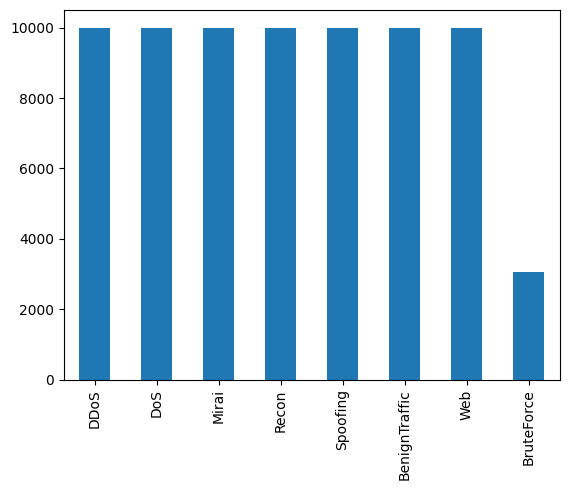

In [31]:
df_test_final.category_label.value_counts().plot(kind='bar')

Here we import our preprocessed dataset to try linear models and see which of them predict better.

## Linear Classifiers

We are going to work with the following linear classifiers:
- Logistic Regression
- Gaussian Naive Bayes
- Support Vector Machine

## Helper Function

In [33]:
def plot_metric(eval_dict, model_name, param_name, param_values, log_scale=False):
    fig, ax = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

    metrics = {
        'Accuracy': 'list_accuracy',
        'Precision': 'list_precision',
        'Recall': 'list_recall',
        'Specificity': 'list_specificity',
        'F1': 'list_f1',
        'Training time': 'list_training_time'
    }

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:olive', 'tab:cyan', 'tab:red']

    for i, (metric_name, metric_key) in enumerate(metrics.items()):
        x_value = list(range(0, len(eval_dict[metric_key])))
        ax[i // 2, i % 2].plot(x_value, eval_dict[metric_key], c=colors[i])
        if log_scale:
            ax[i // 2, i % 2].set_xscale('log')
        
        # Add xticks at the position of the maximum value
        max_idx = np.argmax(eval_dict[metric_key])
        max_value = eval_dict[metric_key][max_idx]
        ax[i // 2, i % 2].axvline(x=x_value[max_idx], color='lightgray', linestyle='--')
        ax[i // 2, i % 2].axhline(y=max_value, color='lightgray', linestyle='--')
        ax[i // 2, i % 2].scatter(x_value[max_idx], max_value, color='red', marker='o')
        ax[i // 2, i % 2].set_xticks(ticks=x_value, labels=param_values, rotation=90)
        
        ax[i // 2, i % 2].set_title(f'{metric_name} ({model_name})')
        ax[i // 2, i % 2].set_xlabel(param_name)
        
        # Add y-axis label (tick) for the maximum value
        ax[i // 2, i % 2].set_ylabel(metric_name)
        yticks = list(ax[i // 2, i % 2].get_yticks())
        del yticks[-2:]
        yticks.append(max_value)
        ax[i // 2, i % 2].set_yticks(yticks)
        if metric_name != 'Training time':
            ax[i // 2, i % 2].text(max_idx, eval_dict[metric_key][np.argmin(eval_dict[metric_key])], f'{param_values[max_idx]}', c='red')
        
    plt.tight_layout()
    plt.show()


## Logistic Regression

Before running the model, we must create a list of parameters for Logistic Regression and a list for each metric we want to evalute. In this case, we have chosen to work on the C parameter (regularization parameter) to look at the behaviour of Logistic Regression.

In [34]:
list_param_LR = np.linspace(0.1, 1.0, 19)
list_param_LR

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [35]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

# Initialize variables to keep track of the best model
best_accuracy = 0.0

for val in list_param_LR:
    # Create classifier instance
    model = LogisticRegression(max_iter=5000, tol=1e-3, C=val)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    model.fit(X_train, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(model, 'models/linear/logistic_best.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

Now we plot the performance.
### Hyperparameter C:
The metrics are based on the hyperparameter C, which:
- The higher the C, the more complex the model is because the regularization is weaker
- The lower the C, the simpler the model is because the regularization is stronger

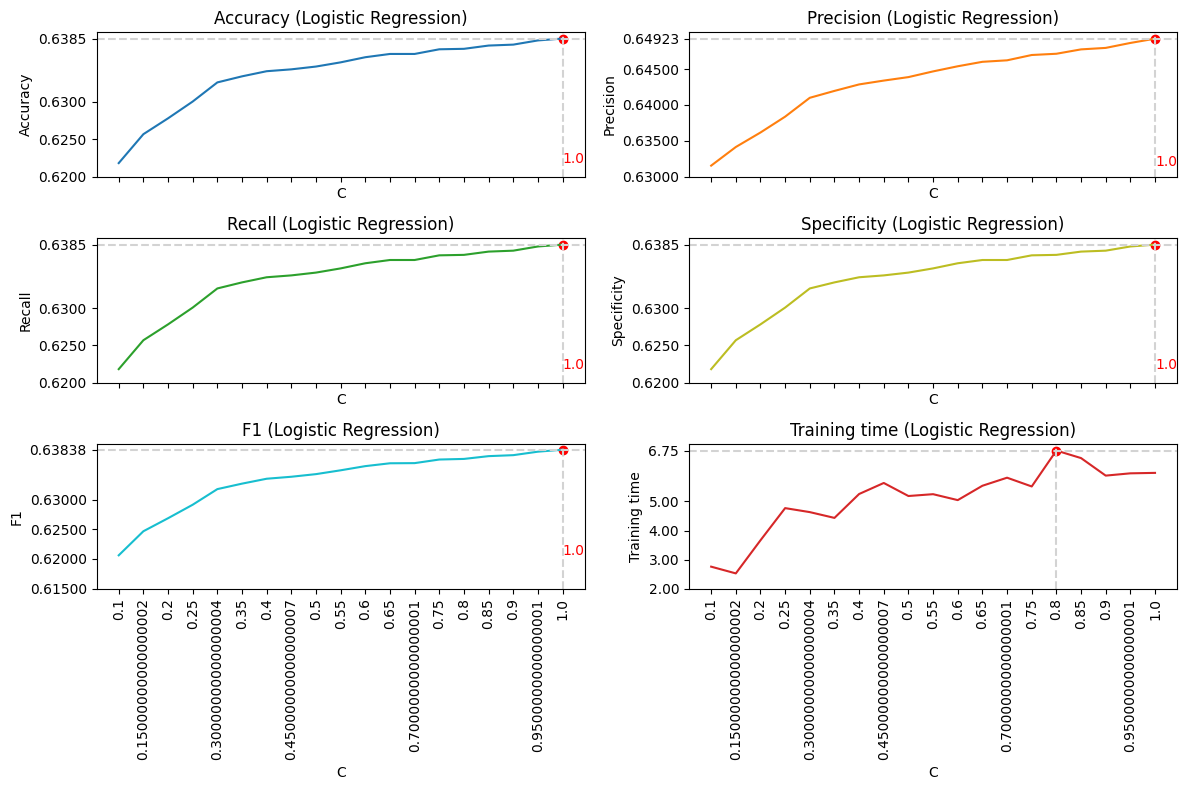

In [36]:
plot_metric(eval_dict, 'Logistic Regression', 'C', list_param_LR)

As we can see, Logistic Regression is very fast by nature but the accuracy metric and others are not so high, which could be considered when evaluating the best model.

Now we run it on the bigger test set. 

In [40]:
clf = load('models/linear/logistic_best.joblib')
y_pred = clf.predict(X_test_final)

In [41]:
print(classification_report(y_test_final, y_pred,target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.65      0.68      0.67     10000
        Mirai       0.99      0.97      0.98     10000
         DDoS       0.80      0.57      0.66     10000
     Spoofing       0.65      0.58      0.62     10000
          Web       0.53      0.53      0.53     10000
        Recon       0.65      0.43      0.52     10000
   BruteForce       0.21      0.51      0.30      3064
          DoS       0.64      0.82      0.72     10000

     accuracy                           0.65     73064
    macro avg       0.64      0.64      0.62     73064
 weighted avg       0.68      0.65      0.65     73064



After rerunning the model on the bigger test set, we can see that the Accuracy metric's difference is almost negligible (.638 and .65 respectively), indicating that the model is not at risk of overfitting.

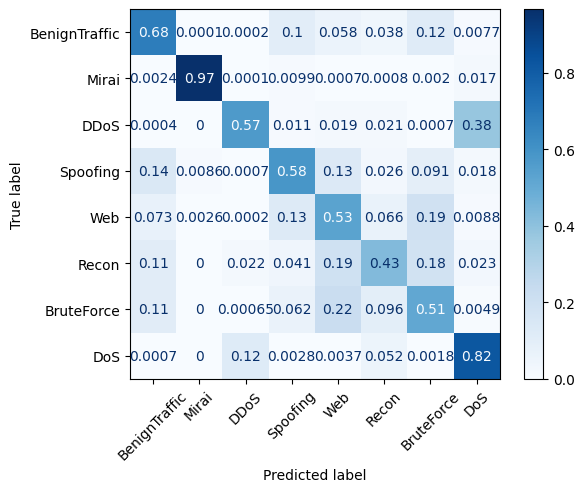

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred, display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

We can see that the model performs especially well when classifying the Mirai attack because 97% of the Mirai attacks have been correctly classified. 
On the other hand, the model performs the worst when classifying the Recon attack, with only about 43% of them being classified correctly. 

### Gaussian Naive Bayes

In Gaussian Naive Bayes we have a parameter that controls the smoothing of the variance. We used default parameters from linear classifiers class exercise.

In [51]:
list_param_NB = np.logspace(0, -9, 19)
list_param_NB

array([1.00000000e+00, 3.16227766e-01, 1.00000000e-01, 3.16227766e-02,
       1.00000000e-02, 3.16227766e-03, 1.00000000e-03, 3.16227766e-04,
       1.00000000e-04, 3.16227766e-05, 1.00000000e-05, 3.16227766e-06,
       1.00000000e-06, 3.16227766e-07, 1.00000000e-07, 3.16227766e-08,
       1.00000000e-08, 3.16227766e-09, 1.00000000e-09])

In [52]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

# Initialize variables to keep track of the best model
best_accuracy = 0.0

for val in list_param_NB:
    # Create classifier instance
    model = GaussianNB(var_smoothing=val)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    model.fit(X_train, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(model, 'models/linear/NB_best.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

## Plotting the Metrics

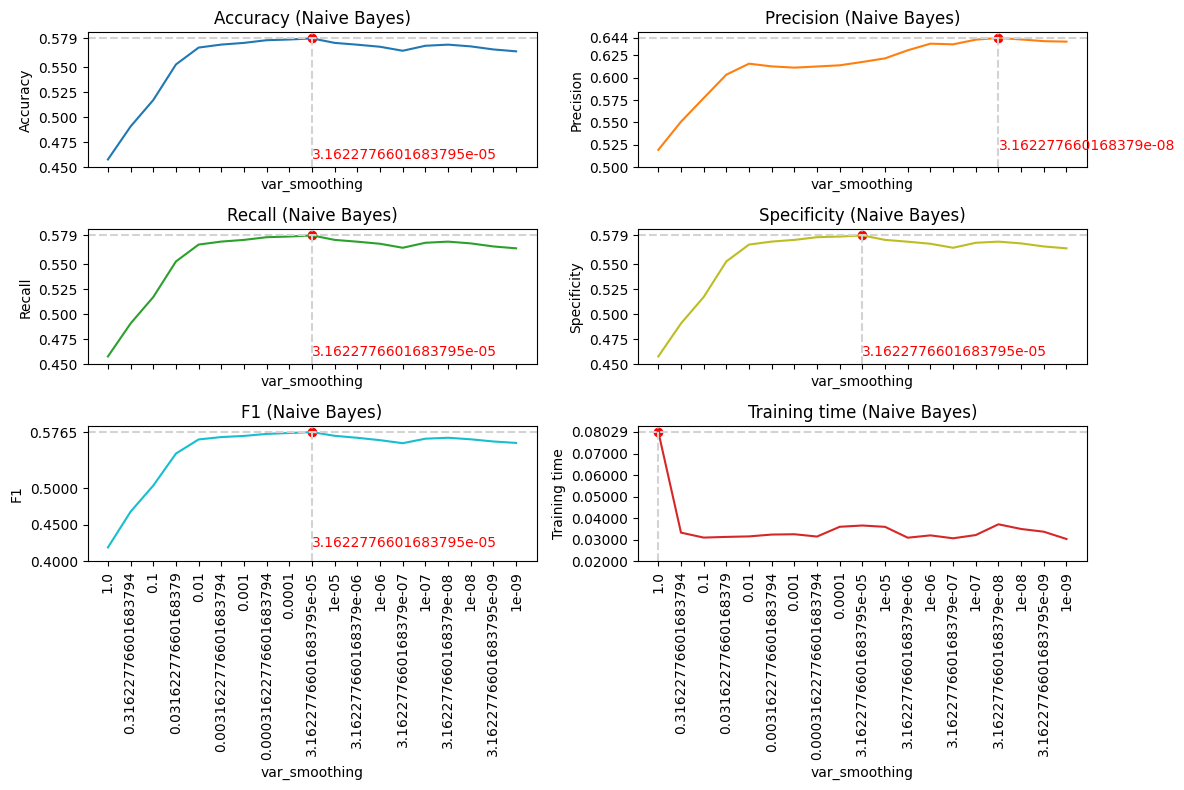

In [53]:
plot_metric(eval_dict, 'Naive Bayes', 'var_smoothing', list_param_NB)

In [54]:
clf = load('models/linear/NB_best.joblib')
y_pred = clf.predict(X_test_final)

In [55]:
print(classification_report(y_test_final, y_pred,target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.49      0.72      0.58     10000
        Mirai       1.00      0.94      0.97     10000
         DDoS       0.85      0.49      0.62     10000
     Spoofing       0.54      0.30      0.39     10000
          Web       0.41      0.51      0.46     10000
        Recon       0.74      0.38      0.50     10000
   BruteForce       0.19      0.41      0.26      3064
          DoS       0.63      0.85      0.72     10000

     accuracy                           0.59     73064
    macro avg       0.61      0.58      0.56     73064
 weighted avg       0.65      0.59      0.59     73064



After rerunning the model on the bigger test set, we can see that the Accuracy metric's difference is once again almost negligible, indicating that the model is not at risk of overfitting.

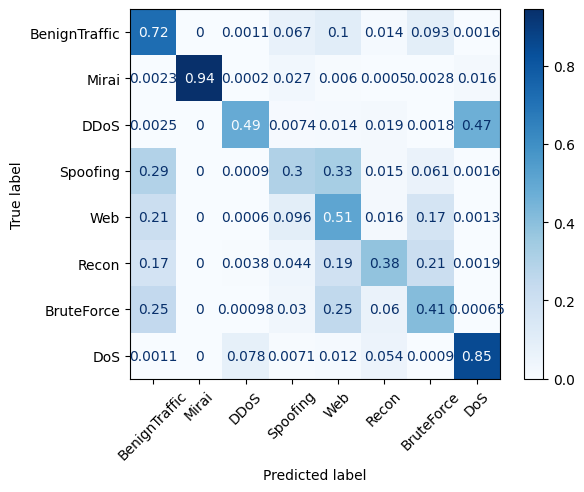

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred, display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

## Linear SVM

The hyperparameter chosen is C, in which:
- For large values of C, the optimization will choose a smaller-margin hyperplane, depending on whether the hyperplane does a better job of getting all the training points classified correctly.  
- For small values of C,  the optimizer will look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points.

In [57]:
list_param_SVM = np.linspace(0.1, 2.0, 20)
list_param_SVM

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [58]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

# Initialize variables to keep track of the best model
best_accuracy = 0.0

for val in list_param_SVM:
    model = LinearSVC(C=val, max_iter=10000)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    model.fit(X_train, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(model, 'models/linear/linearSVC_best.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to

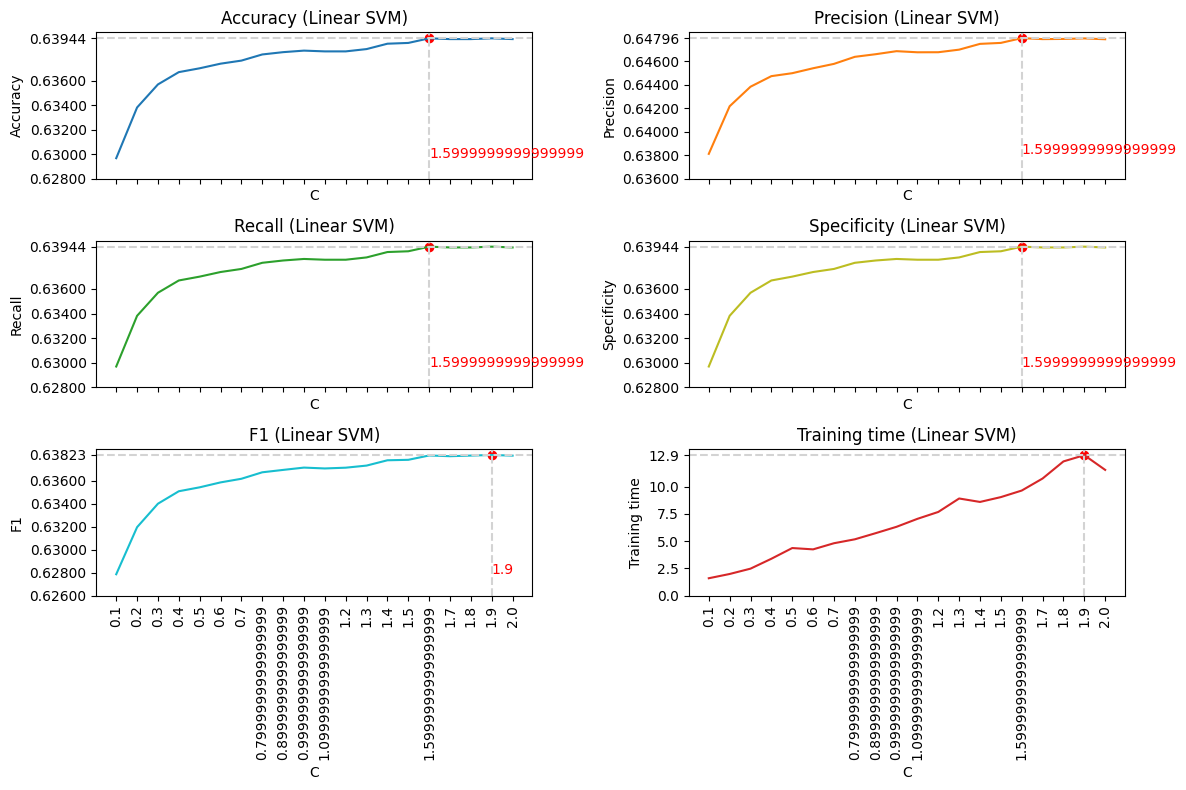

In [59]:
plot_metric(eval_dict, 'Linear SVM', 'C', list_param_SVM)

Above we can see that as C increases (the margin decreases), we see a higher performance of our metrics. 

In [60]:
clf = load('models/linear/linearSVC_best.joblib')
y_pred = clf.predict(X_test_final)

In [61]:
print(classification_report(y_test_final, y_pred,target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.65      0.72      0.68     10000
        Mirai       0.98      0.97      0.98     10000
         DDoS       0.79      0.59      0.67     10000
     Spoofing       0.66      0.56      0.61     10000
          Web       0.54      0.56      0.55     10000
        Recon       0.64      0.42      0.51     10000
   BruteForce       0.22      0.48      0.30      3064
          DoS       0.64      0.81      0.72     10000

     accuracy                           0.65     73064
    macro avg       0.64      0.64      0.63     73064
 weighted avg       0.68      0.65      0.66     73064



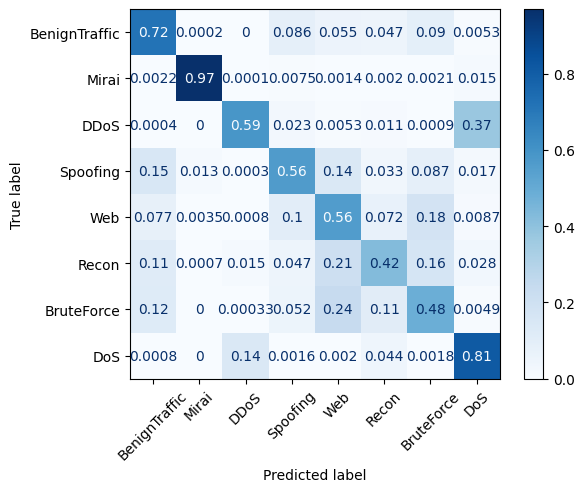

In [62]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred, display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()